# Referral Rates

As a data scientist/analyst, we must have the referral rates by area which we can then use to feed into the D&C model for acute.
The referral rate is the number of referrals per appointment per year. We wish to understand the volume of referrals created by the area that stay within the area (ESNEFT and WSFT) and outside the area.


## Importing libraries

In [2]:
# this is a bit of a hack to get relative imports 
# to work as if these notebooks were in a package
# change cwd to project root if 'notebooks' in PATH
from os import chdir
from pathlib import Path
if 'notebooks' in str(Path.cwd()):
    chdir('..')

# std library
import yaml

#stats/arrays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# project imports from src
from src.schemas import DataCatalog
import src.constants as const
from src.various_methods import PlotCounter
import plotly.graph_objects as go

## Loading from Data Catalog

In [34]:
# load data catalog
data_catalog = DataCatalog.load_from_yaml("data_catalog.yaml")
# keeps track of plot numbers
plot_counter = PlotCounter(name="referral_rate") 

In [110]:
# Loading the Referrals dataframe from 2022
referral_data_catalog_entry_22 = data_catalog.single_data_sources[2]
outpatient_referrals_22 = referral_data_catalog_entry_22.load()
print(referral_data_catalog_entry_22.zip_file.namelist())
print(outpatient_referrals_22.shape)

# Removing unnecessary columns
outpatient_referrals_22 = outpatient_referrals_22.drop(columns=['Unnamed: 13' , 'Unnamed: 14', 'Unnamed: 15'])

['Annual CSV 2022-23 including revisions Oct 22- Feb 23 final 1.csv']
(97108, 16)


In [111]:
# Loading the Referrals dataframe from 2023
referral_data_catalog_entry_23 = data_catalog.single_data_sources[1]
outpatient_referrals_23 = referral_data_catalog_entry_23.load()
print(referral_data_catalog_entry_23.zip_file.namelist())
print(outpatient_referrals_23.shape)

['Annual CSV 2023-24 Published October 2023 HJYTR.csv']
(42436, 13)


In [112]:
# Merging both the dataframes
referrals_df = pd.concat([outpatient_referrals_22, outpatient_referrals_23], ignore_index=True)
print(referrals_df.shape)

# Taking record from September/2022 to August/2023
required_time = ['MRR-September-2022', 'MRR-October-2022','MRR-November-2022', 'MRR-December-2022', 'MRR-January-2023',
       'MRR-February-2023', 'MRR-March-2023', 'MRR-April-2023','MRR-May-2023', 'MRR-June-2023', 'MRR-July-2023','MRR-August-2023']

referrals_df = referrals_df[referrals_df['Periodname'].isin(required_time)].reset_index().drop(columns=['index'])
print(referrals_df.shape)


(139544, 13)
(99577, 13)


In [113]:
referrals_df.head()

,Periodname,Provider Parent org code,Provider Parent name,Provider Org code,Provider Org name,Commissioner Parent Org Code,Commissioner Parent Org Name,Commissioner Org Code,Commissioner Org Name,Op Gprefsmade M,Op Otherrefsmade M,Op Gprefsmade Ga M,Op Otherrefsmade Ga M
0,MRR-September-2022,NaN,NaN,7A1,BETSI CADWALADR UNIVERSITY LHB,QYG,NHS CHESHIRE AND MERSEYSIDE INTEGRATED CARE BOARD,02E,NHS WARRINGTON (SUB ICB LOCATION),1,0,1,0
1,MRR-September-2022,NaN,NaN,7A1,BETSI CADWALADR UNIVERSITY LHB,QYG,NHS CHESHIRE AND MERSEYSIDE INTEGRATED CARE BOARD,12F,NHS WIRRAL (SUB ICB LOCATION),1,0,1,0
2,MRR-September-2022,NaN,NaN,7A1,BETSI CADWALADR UNIVERSITY LHB,QYG,NHS CHESHIRE AND MERSEYSIDE INTEGRATED CARE BOARD,27D,NHS CHESHIRE (SUB ICB LOCATION),5,0,5,0
3,MRR-September-2022,QE1,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,A4M8P,BUCKSHAW HOSPITAL,QHM,NHS NORTH EAST AND NORTH CUMBRIA INTEGRATED CA...,00L,NHS NORTHUMBERLAND (SUB ICB LOCATION),25,0,25,0
4,MRR-September-2022,QE1,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,A4M8P,BUCKSHAW HOSPITAL,QHM,NHS NORTH EAST AND NORTH CUMBRIA INTEGRATED CA...,00N,NHS SOUTH TYNESIDE (SUB ICB LOCATION),10,0,10,0


In [114]:
# Getting the Provider parent org code for SNEE
drow = referrals_df[referrals_df['Provider Parent name'] == 'NHS SUFFOLK AND NORTH EAST ESSEX INTEGRATED CARE BOARD']
print(drow['Provider Parent org code'])

1766     QJG
1767     QJG
1768     QJG
1769     QJG
1770     QJG
        ... 
92753    QJG
92754    QJG
92755    QJG
92756    QJG
92757    QJG
Name: Provider Parent org code, Length: 940, dtype: object


In [115]:
# Only taking required columns and dropping the rest
needed_cols = ['Provider Parent org code','Commissioner Org Code','Op Gprefsmade M','Op Otherrefsmade M']
referrals_df = referrals_df[needed_cols].copy()

# Filling Nan values with others
referrals_df['Provider Parent org code'] = referrals_df['Provider Parent org code'].fillna('Others')

# Keeping records for SNEE and dropping rest
snee_code = ['QJG']
snee_referrals = referrals_df[referrals_df['Provider Parent org code'].isin(snee_code)].reset_index().drop(columns=['index'])

# Replacing the code with SNEE-ICB
snee_referrals['Provider Parent org code'] = snee_referrals['Provider Parent org code'].map({'QJG' : 'SNEE-ICB'})

In [116]:
snee_referrals
#

,Provider Parent org code,Commissioner Org Code,Op Gprefsmade M,Op Otherrefsmade M
0,SNEE-ICB,06Q,61,0
1,SNEE-ICB,X24,1,0
2,SNEE-ICB,06Q,1,0
3,SNEE-ICB,06L,2,1
4,SNEE-ICB,07K,12,3
...,...,...,...,...
935,SNEE-ICB,52R,3,4
936,SNEE-ICB,14Y,1,2
937,SNEE-ICB,06H,19,41
938,SNEE-ICB,15C,1,0


In [121]:
snee_referrals = snee_referrals.groupby(['Provider Parent org code','Commissioner Org Code']).sum()
snee_referrals

Op Gprefsmade M  \
Provider Parent org code Commissioner Org Code                    
SNEE-ICB                 00L                                  0   
                         00N                                  0   
                         00P                                  1   
                         00R                                  0   
                         00T                                  0   
...                                                         ...   
                         M2L0M                                1   
                         NONC                                46   
                         W2U3Z                               29   
                         X24                               1815   
                         X2C4Y                                1   

                                                Op Otherrefsmade M  
Provider Parent org code Commissioner Org Code                      
SNEE-ICB                 00L                                     3  
                         00N                                     2  
                         00P                                     2  
                         00R                                     1  
                         00T                                     1  
...                                                            ...  
                         M2L0M                                   2  
                         NONC                                   89  
                         W2U3Z                                  28  
                         X24                                  2182  
                         X2C4Y                                   2  

[95 rows x 2 columns]

In [73]:
#snee_referral = snee_outpatient_referrals.pivot_table(index=['Commissioner Org Code'], columns=['Provider Org code'], values=['Op Gprefsmade M','Op Otherrefsmade M' ], aggfunc='sum').reset_index()

In [104]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = snee_referrals['Commissioner Org Code'],
      color = "blue"
    ),
    link = dict(
      source = [0,0,1,2,3],
      target = [snee_referrals['Provider Parent org code']],
      value = [snee_referrals['Op Gprefsmade M']]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

In [101]:
!pip install pySankey


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip


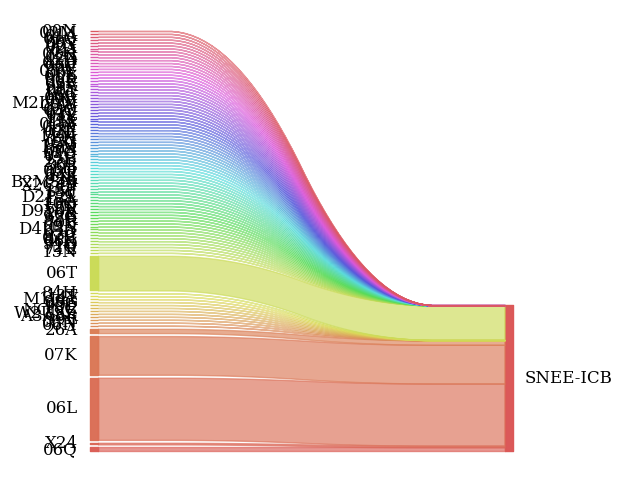

In [105]:
from pySankey.sankey import sankey
sankey (
    left = snee_referrals['Commissioner Org Code'] , right = snee_referrals['Provider Parent org code'],
    leftWeight = snee_referrals['Op Gprefsmade M'] , rightWeight = snee_referrals['Op Gprefsmade M'],
    fontsize = 12
)
plt.show()